## Welcome to the `Intro to Segmentation` Workshop!
In this workshop, we'll learn the concept of how to use FCN (Fully convolutional Networks)for Semantic Segmentation  Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a custom model with pretrained backbone
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

In [1]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.2 MB/s 
     |████████████████████████████████| 376 kB 50.7 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=cc0122187269f7810f6b3127f39872b6ff594ea9164d08a2fdc1c3a9062e1336
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=f10635863e01c63a36cb098bc912c33c7564cd45f6b9089b3ad163d9e7b2dbd4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Basic Imports

In [2]:
# basic imports
import random
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [3]:
ENVIRONMENT = 'colab'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

Mounted at /content/drive


In [4]:
targetWidth = 320
targetHeight = 180

# batch size for data loaders
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 8

# Hyperparameters
N_EPOCHS = 10
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'FCN_resnet50_dilated'

In [5]:
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


## Torch Dataset definition

In [6]:
class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf=None):
        """Dataset class for BDD100k_dataset drivable / segmentation data """
        self.images = images
        self.labels = labels
        self.tf = tf
    
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image  

In [7]:
# Convert to torch tensor and normalize images using Imagenet values
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

data = BDD100k_dataset(images, labels, tf=preprocess)

Splitting Training data into train and validation sets, creating Dataloaders

In [8]:
# split train data into train, validation and test sets
total_count = len(data)
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_set, val_set, test_set = torch.utils.data.random_split(data, 
            (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE)
val_dataloader   = DataLoader(val_set, batch_size=TEST_BATCH_SIZE)
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

Let's verify size of images from the dataset

In [9]:
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

In [10]:
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [ 
             Label("direct", 0, (219, 94, 86)),        # red
             Label("alternative", 1, (86, 211, 219)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black          
            ]
train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


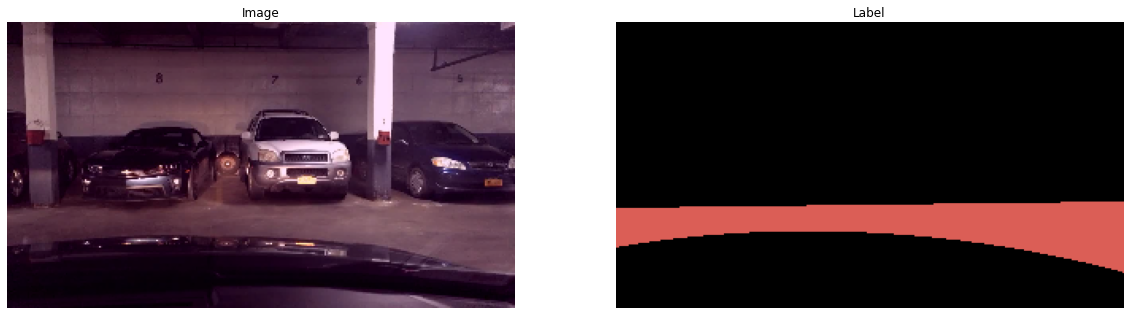

In [11]:
# when using torch datasets we defined earlier, the output image
# is normalized. So we're defining an inverse transformation to 
# transform to normal RGB format
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

rgb_image, label = train_set[random.randint(0, len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define a custom model with pretrained backbone

In [12]:
from torchvision.models import resnet50

class FCN_resnet50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # feature extractor
        self.backbone = resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])

        # layer4 of resnet50 has 2048 layers output
        backbone_output_channels = 2048
        # classifier will have 512 layers
        classifier_channels = 512

        # Classifier head
        self.classifier = nn.Sequential(
                nn.Conv2d(backbone_output_channels, classifier_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(classifier_channels),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(classifier_channels, num_classes, 1)
                )
    
    def forward(self, x):
        # get input shape for upsampling
        input_shape = x.shape[-2:]

        # pass input through the backbone layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # classifier output shape = (batch_size, num_classes, feat_ext_height, feat_ext_width)
        x = self.classifier(x)

        # upsample the classfier output to input shape
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

# 3. Training : Train and validate model on the custom dataset


Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

## Metric - meanIoU

In [13]:
class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        """ Function finds the IoU for the input batch
        and add batch metrics to overall metrics """
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        """ Function to calculate confusion matrix on single batch """
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        """ Computes overall meanIoU metric from confusion matrix data """ 
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return mean_iu

    def reset(self):
        self.iou_metric = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

## Function to plot training curves

In [14]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

## Train validate function

In [15]:
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)                
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [16]:
def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

## Model Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, optimizer, lr_scheduler and pass to training function
model = FCN_resnet50(num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Starting 1 epoch ...


100%|██████████| 86/86 [00:20<00:00,  4.20it/s]


Epoch: 1, trainLoss:0.54819, validationLoss:0.37275, meanIoU: 0.63
Starting 2 epoch ...


 95%|█████████▌| 286/301 [02:14<00:07,  2.12it/s]

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, device)
print(f"\nModel has {test_metric} mean IoU in test set")

In [ ]:
def visualizePredictions(model : torch.nn.Module, dataSet : Dataset,  
                         device :torch.device, numTestSamples : int):
    """Function visualizes predictions of input model on samples from
    cityscapes dataset provided

    Args:
        model (torch.nn.Module): model whose output we're to visualize
        dataSet (Dataset): dataset to take samples from
        device (torch.device): compute device as in GPU, CPU etc
        numTestSamples (int): number of samples to plot
    """
    model.to(device=device)
    model.eval()

    # predictions on random samples
    testSamples = np.random.choice(len(dataSet), numTestSamples).tolist()
    _, axes = plt.subplots(numTestSamples, 3, figsize=(3*6, numTestSamples * 4))
    
    for i, sampleID in enumerate(testSamples):
        inputImage, gt = dataSet[sampleID]

        # input rgb image   
        inputImage = inputImage.to(device)
        landscape = inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()
        axes[i, 0].imshow(landscape)
        axes[i, 0].set_title("Landscape")

        # groundtruth label image
        label_class = gt.cpu().detach().numpy()
        axes[i, 1].imshow(train_id_to_color[label_class])
        axes[i, 1].set_title("Groudtruth Label")

        # predicted label image
        y_pred = torch.argmax(model(inputImage.unsqueeze(0)), dim=1).squeeze(0)
        label_class_predicted = y_pred.cpu().detach().numpy()    
        axes[i, 2].imshow(train_id_to_color[label_class_predicted])
        axes[i, 2].set_title("Predicted Label")

    plt.show()

In [ ]:
visualizePredictions(model, test_set, device, numTestSamples=2)

## Test on sample video

In [ ]:
input_video_path = f'{dataset_path}/bdd100k_test_{targetWidth}_{targetHeight}.avi'
output_video_path = f'{output_path}/{MODEL_NAME}_output_{targetWidth}_{targetHeight}.avi'

# handles for input output videos
input_handle = cv2.VideoCapture(input_video_path)
output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 5, (targetWidth, targetHeight))

# create progress bar
num_frames = int(input_handle.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total = num_frames, position=0, leave=True)

while(input_handle.isOpened()):
    ret, frame = input_handle.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # create torch tensor to give as input to model
        pt_image = preprocess(frame)
        pt_image = pt_image.to(device)

        # get model prediction and convert to corresponding color
        y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
        predicted_labels = y_pred.cpu().detach().numpy()
        cm_labels = (train_id_to_color[predicted_labels]).astype(np.uint8)

        # overlay prediction over input frame
        overlay_image = cv2.addWeighted(frame, 1, cm_labels, 0.25, 0)
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

        # write output result and update progress
        output_handle.write(overlay_image)
        pbar.update(1)

    else:
        break

output_handle.release()
input_handle.release()